# A Simple Market Timing Algorithm

## 1 - Introduction

### 1.1 - Background
This notebook takes the simplest iteration that was discovered out of the market timing research  as a proof of concept. 


***Key Goal***: Market Timing Algoithm that buys when the price is relatively high and sell when the price is relatively low.
- *Pricing Mechanism*: OLS Time Series Regression
- *Timing Mechanism*: Average of the Absolute Value of the Standard Error
- *Buy/Sell Weight Mechanism*: Simple percent, with simple sophistications around momentum

These will de discussed in more detail in the relevant sections.


In [1]:
%%html 
<style>
table {float:left}
</style>

### 1.2 - Data
This model uses daily S&P500 data. <br>
*Source:* https://www.kaggle.com/datasets/pdquant/sp500-daily-19862018?resource=download


| Metric      | Value       | Metric      | Value       |
| ----------- | ----------- | ----------- | ----------- |
| Frequency   | Daily (B)   | Count       | 8192        |
| Start Year  | 02-Jan-1986 | Mean        | 1070        |
| End Year    | 29-Jun-2018 | Max         | 2872        | 
| Periods     | 8192        | StD         | 616         |


### 1.3 - Inflation
In order to adjust for the real value of money, we adjust our dataset using monthly CPI data. Note that there is a period mismatch between our daily stock data and monthly inflation data. To solve this, inflation is assumed constant to be constant for the whole month. 
- *Source*: https://data.bls.gov/
- *Series Title*: All items in U.S. city average, all urban consumers, not seasonally adjusted
- *Area*: U.S. city average
- *Base Period*:  1982-84=100


<div class="alert alert-block alert-info">
<b>Theory</b> <br><em>Inflation adjustment, or "deflation", is accomplished by dividing a monetary time series by a price index, such as the Consumer Price Index (CPI). The deflated series is then said to be measured in "constant dollars," whereas the original series was measured in "nominal dollars" or "current dollars."</em> <br> Source:https://people.duke.edu/~rnau/411infla.htm
</div>

## 2 - Preparing S&P Data

### 2.1 - Importing modules

In [2]:
import os
import pandas as pd 
import numpy as np 
import matplotlib as plt 
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
sns.set_style("white")
sns.set_palette("deep")

### 2.2 - Changing the directory

In [3]:
env = os.chdir(r'C:\Users\alexb\OneDrive\Documents\02 - Work\coding\TimeSeries')
path = os.getcwd()
path

'C:\\Users\\alexb\\OneDrive\\Documents\\02 - Work\\coding\\TimeSeries'

### 2.3 - Downloading the data

In [4]:
df1 = pd.read_csv("spx.csv", infer_datetime_format = True)
df1['date'] = pd.to_datetime(df1['date'])   # Setting date to datetime format. Don't rerun 

df1.head(5)

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [5]:
df1.dtypes

date     datetime64[ns]
close           float64
dtype: object

### 2.4 - Creating iterable index column

This will make our life easier as we begin looping through the set

In [6]:
df1['index'] = df1.index.values
df1.tail(5)

,date,close,index
8187,2018-06-25,2717.07,8187
8188,2018-06-26,2723.06,8188
8189,2018-06-27,2699.63,8189
8190,2018-06-28,2716.31,8190
8191,2018-06-29,2718.37,8191


### Section 2 Output

*Dataframes*
- df1: S&P 500 daily close
    - Date (datetime format)
    - Close (float)
    - Index (int)

## 3 - Adjusting for Inflation

### 3.1 - Importing Inflation Dataset

In [7]:
cpi = pd.read_csv("cpi.csv", infer_datetime_format = True)
#cpi.head(4)

In [8]:
cpi['Date'] = pd.to_datetime(cpi['Date'], format='%d-%m-%Y')

In [9]:
cpi.head(3)

,Date,Price
0,1986-01-01,109.6
1,1986-02-01,109.3
2,1986-03-01,108.8


In [10]:
cpi.dtypes

Date     datetime64[ns]
Price           float64
dtype: object

### 3.2 - Merging CPI Data

Strategy:
- Create list of month_year combinations in CPI dataframe
- Create list of month_year combinations in S&P dataframe
- Merge value if they equal each other

#### 3.2.1 - Converting date to monthly for both datasets

In [11]:
cpi['month_year'] = cpi['Date'].dt.to_period('M')
cpi.head(5)

,Date,Price,month_year
0,1986-01-01,109.6,1986-01
1,1986-02-01,109.3,1986-02
2,1986-03-01,108.8,1986-03
3,1986-04-01,108.6,1986-04
4,1986-05-01,108.9,1986-05


In [12]:
df1['month_year'] = df1['date'].dt.to_period('M')
df1.head(5)

,date,close,index,month_year
0,1986-01-02,209.59,0,1986-01
1,1986-01-03,210.88,1,1986-01
2,1986-01-06,210.65,2,1986-01
3,1986-01-07,213.80,3,1986-01
4,1986-01-08,207.97,4,1986-01


#### 3.2.2 - Creating lists to append

In [13]:
date_list = pd.to_datetime(df1['date'])
date_list.head(6)

0   1986-01-02
1   1986-01-03
2   1986-01-06
3   1986-01-07
4   1986-01-08
5   1986-01-09
Name: date, dtype: datetime64[ns]

#### 3.2.3 - Appending dats to DF1

In [14]:
temp_list = []
i = 0

for i in range(len(df1)):
    sp_date = df1.iloc[i,3]
    cpi_index = cpi[cpi['month_year']==sp_date].index.values
    cpi_index = cpi_index[0]
    cpi_value = cpi.iloc[cpi_index,1]
    temp_list.append(cpi_value)
    
    i = i + 1

df1["cpi"] = temp_list

df1.tail(5)

,date,close,index,month_year,cpi
8187,2018-06-25,2717.07,8187,2018-06,251.989
8188,2018-06-26,2723.06,8188,2018-06,251.989
8189,2018-06-27,2699.63,8189,2018-06,251.989
8190,2018-06-28,2716.31,8190,2018-06,251.989
8191,2018-06-29,2718.37,8191,2018-06,251.989


### 3.3 - Calculating Adjusted Price

In [15]:
df1['price'] = (df1['close'] / df1['cpi']) * 100
df1.head(5)

,date,close,index,month_year,cpi,price
0,1986-01-02,209.59,0,1986-01,109.6,191.231752
1,1986-01-03,210.88,1,1986-01,109.6,192.408759
2,1986-01-06,210.65,2,1986-01,109.6,192.198905
3,1986-01-07,213.80,3,1986-01,109.6,195.072993
4,1986-01-08,207.97,4,1986-01,109.6,189.753650


In [16]:
exclusions = ["month_year","cpi","close"]
i = 0
while i < len(exclusions):
    df1.drop(exclusions[i], inplace=True, axis=1)
    i = i + 1

df1.head(6)

,date,index,price
0,1986-01-02,0,191.231752
1,1986-01-03,1,192.408759
2,1986-01-06,2,192.198905
3,1986-01-07,3,195.072993
4,1986-01-08,4,189.753650
5,1986-01-09,5,188.056569


In [17]:
first_column = df1.pop('index')
df1.insert(0, 'index', first_column)
df1.head(5)

,index,date,price
0,0,1986-01-02,191.231752
1,1,1986-01-03,192.408759
2,2,1986-01-06,192.198905
3,3,1986-01-07,195.072993
4,4,1986-01-08,189.753650


### 3.3 - Plotting

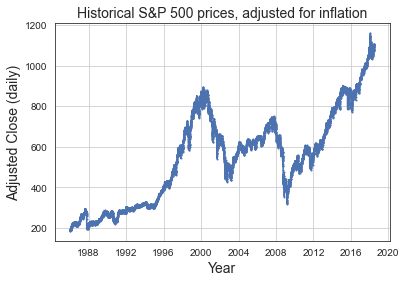

In [18]:
plt.plot(df1['date'], df1['price'], marker='o',ms=1) #color='red'
plt.title('Historical S&P 500 prices, adjusted for inflation', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Adjusted Close (daily)', fontsize=14)
plt.grid(True)
plt.show()

### Section 3 Output

*Dataframes*
- df1: S&P 500 daily close
    - Date (datetime format)
    - Price (float)
    - Index (int)
    
Potential To Dos:
- Add inflation (year-on-year) to the analysis
- Add interest rates to the analysis

## 4 - Building Functions for Sampling and Regression

### 4.1 - Function for sampling a cross-section of data

<div class="alert alert-block alert-success">
<b>Purpose</b> <br><em>A function that takes as input an index i (that corresponds to a row in DF1), and returns an array including the SnP price data for indexes (i) to (i + bin) size</em> <br>
</div>

#### 4.1.1 - Assumptions
Key Assumption: Regression window. For this iteration, we use a ***10-year regression window***. Note, we can let this by dynamically changeable in later versions of the app

In [19]:
days_in_week = 5
weeks_in_year = 52
years_in_window = 10

bin_size = days_in_week*weeks_in_year*years_in_window
bin_size

2600

#### 4.1.2 - Defining the function

Note, we subtract so that the window is backwards looking from time t. In other words, we ask the question, what has the trend been for the last N years.

In [20]:
def gen_sample_df(i):
    start = i - bin_size
    if start < 0:
        start = 0
    end = i 
    temp_df = df1.iloc[start:end, 0:3]
    temp_df = pd.DataFrame(data=temp_df)
    return temp_df


a = gen_sample_df(2000)
a

,index,date,price
0,0,1986-01-02,191.231752
1,1,1986-01-03,192.408759
2,2,1986-01-06,192.198905
3,3,1986-01-07,195.072993
4,4,1986-01-08,189.753650
...,...,...,...
1995,1995,1993-11-19,317.283951
1996,1996,1993-11-22,314.903978
1997,1997,1993-11-23,316.207133
1998,1998,1993-11-24,317.119342


### 4.2 - Define function to regress over sample

<div class="alert alert-block alert-success">
<b>Purpose</b> <br><em>A function that takes as input a time series and ouputs a dictionary including: i) the predicted price at time t, ii) the mean standard error </em> <br>
</div>

*Note on Standard Error*. The simplest sensible error measure that came out of the research was the mean of the sum of the asbolute value of the model errors. This gave us the purest sense of the predictive distance from actual to be able to compare our results against. 

In [21]:
def sample_OLS(temp_df):
    sample = temp_df
    x = sample['index'].values.reshape(-1, 1)
    y = sample['price'].values
    regr = linear_model.LinearRegression()
    regr.fit(x,y)

#-----------------Regression has been run------------#
    
    predicted = regr.predict(x)
    actual = sample['price']
    actual = np.array(actual)
    
    diffs = []
    tru_diffs = []
    
    for i in range(len(actual)):
        diff = actual[i] - predicted[i]
        diffs.append(diff)
    
    abs_diffs =  [abs(i) for i in diffs]
    sample['error'] = abs_diffs
    sample['true_error'] = diffs
    return sample

b = sample_OLS(a)
b

,index,date,price,error,true_error
0,0,1986-01-02,191.231752,21.276993,-21.276993
1,1,1986-01-03,192.408759,20.148667,-20.148667
2,2,1986-01-06,192.198905,20.407203,-20.407203
3,3,1986-01-07,195.072993,17.581797,-17.581797
4,4,1986-01-08,189.753650,22.949821,-22.949821
...,...,...,...,...,...
1995,1995,1993-11-19,317.283951,7.655531,7.655531
1996,1996,1993-11-22,314.903978,5.226877,5.226877
1997,1997,1993-11-23,316.207133,6.481351,6.481351
1998,1998,1993-11-24,317.119342,7.344878,7.344878


### 4.3 - Defining function to check which threshold our value is in

<div class="alert alert-block alert-success">
<b>Purpose</b> <br>Generate a series of threshold based on the sample standard deviation. The function takes as input the sample standard deviation and price at time t. As output, it returns the classification <br><em> </em> <br>
</div>

#### 4.3.1 - Defining the thresholds

<div>
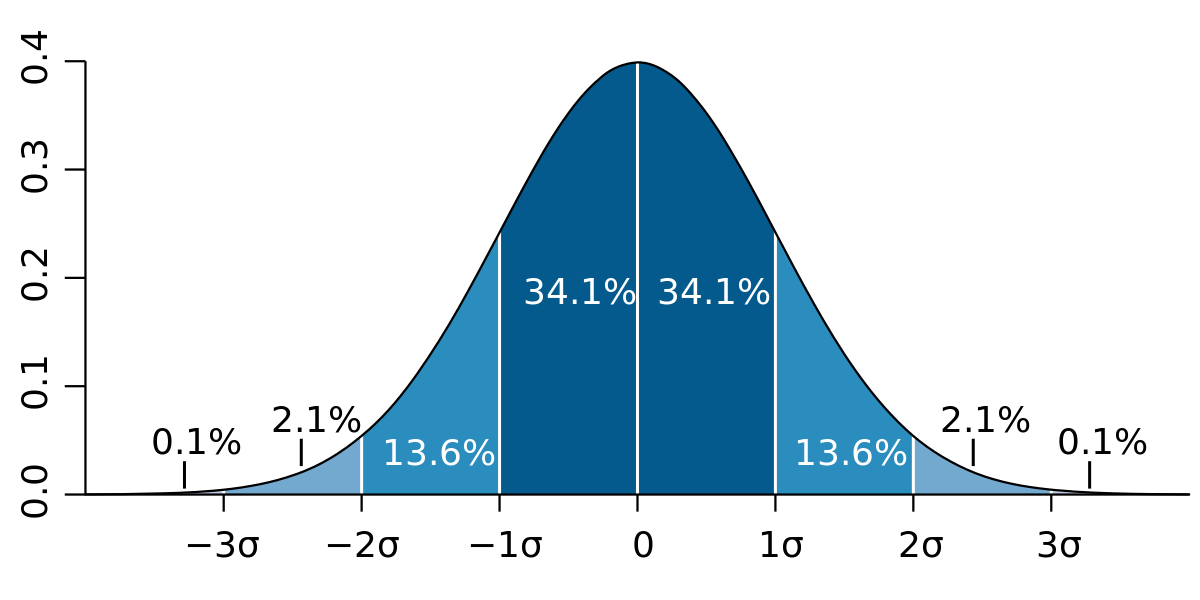
</div>

#### 4.3.2 - Function to return classification, given a set of bands

In [22]:
def check_value(error,stdev):
    
    band1_bottom = 0
    band1_top = 0.5 * stdev
    band2_bottom = 0.5 * stdev + 0.000001
    band2_top = stdev 
    band3_bottom = stdev + 0.000001
    band3_top = 1.5 * stdev
    band4_bottom = 1.5 * stdev + 0.000001
    band4_top = 2 * stdev
    band5_bottom = 2 * stdev + 0.000001
    band5_top = 2.5 * stdev
    band6_bottom = 2.5 * stdev + 0.000001
    band6_top = 3 * stdev
    
    if band1_bottom < error < band1_top:
        return 1
    if band2_bottom < error < band2_top:
        return 2
    if band3_bottom < error < band3_top:
        return 3
    if band4_bottom < error < band4_top:
        return 4
    if band5_bottom < error < band5_top:
        return 5
    if band6_bottom < error < band6_top:
        return 6
    if error > band6_top:
        return 7

#### 4.3.3 - Function to return classification

In [23]:
def classify_price(sample): 
    stdev = sample['error'].std()   
    last_value = sample["error"].iloc[-1]
    check = check_value(last_value,stdev)
    last_error = sample["true_error"].iloc[-1]
    
    if last_error < 0:
        check = check * (-1)
    
    return check

test = classify_price(b)
test

2

## 5 - Creating Buy/Sell Function

<div class="alert alert-block alert-success">
<b>Purpose</b> <br><em>Loop through each row of the price data. For each of the rows, determine the category. If the category is 6, buy/sell 5 %. If it is cat 7, buy/sell 10%. Move 5 days forward. </em> <br>
</div>

Output: Buy or sell amount
Input: final value, category

Actually: first, append category to df1
NExt append buy/sell (in form of 0,-1,1 as we will be multiplying by negative for Sell
Next, append buy/sell amount 
Finally run the wallet

### 5.1 - Generate sample and call functions

In [24]:
categories = []

for i in range(len(df1)):
    if i < 4:
        categories.append(0)
        i = i + 1
    else: 
        sample = gen_sample_df(i)
        regression = sample_OLS(sample)
        category = classify_price(sample)
        categories.append(category)
        i = i + 1

#print(categories)

df1['classification'] = categories
df1.head(5)

,index,date,price,classification
0,0,1986-01-02,191.231752,0
1,1,1986-01-03,192.408759,0
2,2,1986-01-06,192.198905,0
3,3,1986-01-07,195.072993,0
4,4,1986-01-08,189.753650,4


### 5.2 - Plotting classifications

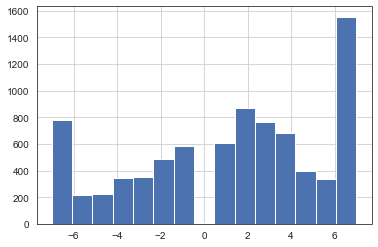

In [25]:
hist = df1['classification'].hist(bins=15)

From this, there might be an issue with the error calculations, or thresholds given the extremes on either ends. Might have to look at this deeper late

### 5.3 - Defining buy/sell weights

In [26]:
top_weight = 0.15
bot_weight = 0.10

### 5.4 - Defining buy/sell assumptions

In [27]:
start_value = df1.iloc[0,2] # 191.23175182481754

In [28]:
# To record ticket value and number of shares for each buy/sell
trans_value = []
trans_shares = []

# To record our bank, total capital invested and how much we have left in the bank
running_holdings = []
running_bank = []
running_shares = []

# Starting value for our counters
i = 0
buy_count = 0
sell_count = 0

# Starting value for our function
holdings = 1
bank = 1000000
holdings_in_shares = holdings / start_value

### 5.5 - Buying Function

What I want as output
- Price of stock
- Classification
- Ticket Value
- Ticket Shares
- Capital Invested
- Capital

In [29]:
for i in range(len(df1)):
    classification = df1.iloc[i,3] 
    share_price = df1.iloc[i,2]
    
    holdings = holdings_in_shares * share_price
    
    if classification == 6:
        if holdings > share_price:    # could replace 10 with share_price
            ticket_size = -(holdings * bot_weight)
            trans_value.append(ticket_size)
            
            ticket_shares = ticket_size / share_price
            trans_shares.append(ticket_shares)
            
            bank = bank - ticket_size # Money leaves bank. Ticket size is negative for sales , in which case the bank is credited
            running_bank.append(bank)
            
            holdings = holdings + ticket_size  # Investment account goes up/down by value of sale
            running_holdings.append(holdings)
            
            holdings_in_shares = holdings_in_shares + ticket_shares
            running_shares.append(holdings_in_shares)
            
            sell_count = sell_count + 1
            i = i + 1

        else:
            trans_value.append(0)
            trans_shares.append(0)
            running_bank.append(bank)  # Should still equal what it was the loop before
            running_holdings.append(holdings)
            running_shares.append(holdings_in_shares)
            i = i + 1

    elif classification == 7:
        if holdings > share_price:    # could replace 10 with share_price
            ticket_size = -(holdings * top_weight)
            trans_value.append(ticket_size)
            
            ticket_shares = ticket_size / share_price
            trans_shares.append(ticket_shares)
            
            bank = bank - ticket_size # Money leaves bank. Ticket size is negative for sales , in which case the bank is credited
            running_bank.append(bank)
            
            holdings = holdings + ticket_size  # Investment account goes up/down by value of sale
            running_holdings.append(holdings)
            
            holdings_in_shares = holdings_in_shares + ticket_shares
            running_shares.append(holdings_in_shares)
            
            sell_count = sell_count + 1
            i = i + 1

        else:
            trans_value.append(0)
            trans_shares.append(0)
            running_bank.append(bank)         # Should still equal what it was the loop before
            running_holdings.append(holdings)
            running_shares.append(holdings_in_shares)
            i = i + 1

    elif classification == -6:                # This represents a buy
        if bank > share_price:            # For buy, bank was changed to holdings, and negative sign removed
            ticket_size = bank * bot_weight # For buy, weighting determined by bank, not holding
            trans_value.append(ticket_size)
            
            ticket_shares = ticket_size / share_price
            trans_shares.append(ticket_shares)
            
            bank = bank - ticket_size # Money leaves bank. Ticket size is negative for sales , in which case the bank is credited
            running_bank.append(bank)
            
            holdings = holdings + ticket_size  # Investment account goes up/down by value of sale
            running_holdings.append(holdings)
            
            holdings_in_shares = holdings_in_shares + ticket_shares
            running_shares.append(holdings_in_shares)
            
            buy_count = buy_count + 1    # Changed to buy count
            i = i + 1

        else:
            trans_value.append(0)
            trans_shares.append(0)
            running_bank.append(bank)  # Should still equal what it was the loop before
            running_holdings.append(holdings)
            running_shares.append(holdings_in_shares)
            i = i + 1

    elif classification == -7:                # This represents a buy
        if bank > share_price:            # For buy, bank was changed to holdings, and negative sign removed
            ticket_size = bank * top_weight # For buy, weighting determined by bank, not holding
            trans_value.append(ticket_size)
            
            ticket_shares = ticket_size / share_price
            trans_shares.append(ticket_shares)
            
            bank = bank - ticket_size # Money leaves bank. Ticket size is negative for sales , in which case the bank is credited
            running_bank.append(bank)
            
            holdings = holdings + ticket_size  # Investment account goes up/down by value of sale
            running_holdings.append(holdings)
            
            holdings_in_shares = holdings_in_shares + ticket_shares
            running_shares.append(holdings_in_shares)
            
            buy_count = buy_count + 1    # Changed to buy count
            i = i + 1

        else:
            trans_value.append(0)
            trans_shares.append(0)
            running_bank.append(bank)  # Should still equal what it was the loop before
            running_holdings.append(holdings)
            running_shares.append(holdings_in_shares)
            i = i + 1
            
    else:
        trans_value.append(0)
        trans_shares.append(0)
        running_bank.append(bank)  # Should still equal what it was the loop before
        running_holdings.append(holdings)
        running_shares.append(holdings_in_shares)
        i = i + 1

        
print(bank)
print(holdings)
print(holdings_in_shares)
print(buy_count)
print(sell_count)

2211426.9904333195
993.823794622446
0.9212604030471039
210
210


### 5. 6 - Full Table

In [30]:
pd.set_option('display.max_rows', None, 'display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

In [44]:
df1['transaction value'] = trans_value
df1['transaction shares'] = trans_shares

df1['holdings'] = running_holdings
df1['bank'] = running_bank
df1['no shares'] = running_shares
df1['pps'] = df1['holdings'] / df1['no shares']

df1.tail(10)

,index,date,price,classification,transaction value,transaction shares,holdings,bank,no shares,pps
8182,8182,2018-06-18,"1,100.74",4,0.00,0.00,"1,014.07","2,211,426.99",0.92,"1,100.74"
8183,8183,2018-06-19,"1,096.31",4,0.00,0.00,"1,009.99","2,211,426.99",0.92,"1,096.31"
8184,8184,2018-06-20,"1,098.19",3,0.00,0.00,"1,011.72","2,211,426.99",0.92,"1,098.19"
8185,8185,2018-06-21,"1,091.22",3,0.00,0.00,"1,005.30","2,211,426.99",0.92,"1,091.22"
8186,8186,2018-06-22,"1,093.25",3,0.00,0.00,"1,007.17","2,211,426.99",0.92,"1,093.25"
8187,8187,2018-06-25,"1,078.25",3,0.00,0.00,993.35,"2,211,426.99",0.92,"1,078.25"
8188,8188,2018-06-26,"1,080.63",2,0.00,0.00,995.54,"2,211,426.99",0.92,"1,080.63"
8189,8189,2018-06-27,"1,071.33",3,0.00,0.00,986.97,"2,211,426.99",0.92,"1,071.33"
8190,8190,2018-06-28,"1,077.95",2,0.00,0.00,993.07,"2,211,426.99",0.92,"1,077.95"
8191,8191,2018-06-29,"1,078.77",2,0.00,0.00,993.82,"2,211,426.99",0.92,"1,078.77"


# 6 - Evaluating

### 6.1 - Model Stats

### 6.2 - Graphic Visualisation

*Goals*
- Chart 1: SnP 500 price, with the buy and sell points highlighted

<AxesSubplot:>

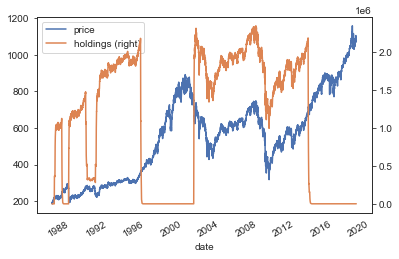

In [38]:
fig, ax = plt.subplots() # Create the figure and axes object

# Plot the first x and y axes:
df1.plot(x = 'date', y = 'price', ax = ax) 
# Plot the second x and y axes. By secondary_y = True a second y-axis is requested:
# (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html for details)
df1.plot(x = 'date', y = 'holdings', ax = ax, secondary_y = True) 

This shows pretty clearly one of the issues is that we are selling far before the main market goes up. We also do not seem to be able to capitalise on the losses in 2012, potentially this is because 2021 is still on trend somehow

The purchase in 204 is interesting (experienced an almost immediate loss), is that because the trendline went up so much? Actually it looks like the same problem as on the upside, just sold to early

Also not sure why I wasn't buying in 2008. or maybe I was but the wallet was empty

Solutions: 
- Longer window: Would this do anything? if you made it as lo
- Step more than 1 forward when buying . We hit a number of +7s in a row, so we could move i+1 to i + 5. Problem is that the arrays would no longer be the same size, so it would take some finaigling
- Create counters, that add weights to a buy or sell bucket. It would be interesting if you could look at the momentum as well from one day to the next. It looks like you have a decent number of days before your investments are gone entirely

### 6.3 - Competitor Model

We need to find a reasonable comparison , how much would we have made if we just had our money sit in the stock market from the start ? 

In [40]:
first_value = df1.iloc[0,2]
competitor_holdings = 1000000
shares = competitor_holdings / first_value
print(shares)

5229.257121045851


In [41]:
final_value = df1["price"].iloc[-1]
print(final_value)

1078.7653429316358


In [42]:
grand_total = final_value * shares
print(grand_total)

5641141.351462726


This is what our money would be worth had we just had it sit in the bank. We've got a three mln whole to fill. 

## X - Utility and Functions

### X.1 - Websites
- https://www.ibm.com/docs/en/watson-studio-local/1.2.3?topic=notebooks-markdown-jupyter-cheatsheet
- https://seaborn.pydata.org/tutorial/color_palettes.html

In [ ]:
plt.plot(df['Year'], df['Unemployment_Rate'], color='red', marker='o')
plt.title('Unemployment Rate Vs Year', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Unemployment Rate', fontsize=14)
plt.grid(True)
plt.show()